In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from selenium import webdriver
from geopy.geocoders import Nominatim
import json
import requests
from math import sqrt
import numpy as np
import rsome as rso
from rsome import ro
from rsome import ort_solver as solver
import folium
import ipywidgets as widgets
import random
import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings

In [2]:
warnings.filterwarnings('ignore')

### 1. Use webdriver to put website into state of scrapping

In [ ]:
baseUrl = "https://www.oeps.at/de/termine"
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('headless')

#Create the webdriver instance
browser = webdriver.Chrome("./chromedriver", options=chrome_options)

#Open the url
browser.get(baseUrl)

#Find element to filter for the whole year data
dropdown = browser.find_element_by_xpath('/html/body/main/div[1]/div/div/div/div[2]/form/span[1]/select[1]')
dropdown.click()

#Click
option = browser.find_element_by_xpath("/html/body/main/div[1]/div/div/div/div[2]/form/span[1]/select[1]/option[1]")
option.click()

#Submit
submit = browser.find_element_by_xpath("/html/body/main/div[1]/div/div/div/div[2]/form/input")
submit.click()

#Get data
all_data = browser.find_element_by_class_name("appointmentslist").text

### 2. Scrap data from website and assemble it into a dataframe

In [ ]:
#Convert month names into numerics
months_conversion = {
    "Jänner":1,
    "Februar":2,
    "März":3,
    "April":4,
    "Mai":5,
    "Juni":6,
    "Juli":7,
    "August":8,
    "September":9,
    "Oktober":10,
    "November":11,
    "Dezember":12
}

In [ ]:
#Connect bs4 to selenium
html = browser.page_source

#Instantiate soup instance
soup = BeautifulSoup(html, 'lxml')

#Get main appointment list
main_div = soup.find('div', class_='appointmentslist')

#Get all appointments for competitions
all_divs = main_div.find_all("div", class_="appointment")

#Final data
data = []

for test in all_divs:
    
    curr = {}
    
    #Month & date
    full_date = test.find("div", class_="date").text
    
    #Only get the start of the competition to determine the week
    date = " ".join(full_date.split()).split()
    month = months_conversion[date[0]]
    start_date = date[1]
    
    #Tournament category
    category = test.find("div", class_="category").text
    category = category.split()
    
    #We only want showjumping competitions
    category = list(filter(lambda x: "S" in x,category))
    
    #If the list is empty (as we know that S stands for jumping) we drop this competition
    if len(category) == 0:
        continue
        
    category = ", ".join(category)
    
    #Location
    location = test.find("div", class_="location").text.split()
    
    #Only want the city or village of the location
    location = " ".join(location[1:])
    
    #Assemble dictionary
    curr["Month"] = month
    curr["Date"] = start_date
    curr["Destination"] = location
    curr["Category"] = category
    
    #Append to data
    data.append(curr)
    
#Close browser
browser.close()
    
data = pd.DataFrame(data)
    

In [ ]:
#Final data after webscraping
data

### 3. Use Maps API to find distance between home base and tournament to get transportation cost

#### The distance is used to calculate the transportation cost if the manager decides to send the horses, which in the model will be considered a fixed cost

##### First, I map the latitude and longitude to every location and then I find the driving distance between the home base and the location

In [ ]:
"""From my previous runs, I saw that some locations cannot be mapped to lat long given by the webiste. 
So I used the actual address of the location or a larger location close by."""

bad_loc = {
    "St. Margarethen-Stückler": "Reiterhofstraße 38, 9412 Wolfsberg, Austria",
    "Auhof Neufeld": "Neufeld an Leitha",
    "Treffen - GHPC": "Gaston Glock Straße 8, 9521 Treffen am Ossiacher See, Austria",
    "Wien-Freudenau/ASKÖ":"Freudenau 555, 1020 Wien, Austria"
}

In [ ]:
#My base location was my old horse riding stable
data["Origin"] = "Zwentendorf"
geolocator = Nominatim(user_agent="Leo")
home = geolocator.geocode("Zwentendorf")

#Add lat and long to all destinations
def lat_long(address):
    
    geolocator = Nominatim(user_agent="Leo")
    location = geolocator.geocode(address)
    
    if not location:
        location = geolocator.geocode(bad_loc[address])
    
    return [location.longitude, location.latitude]

#Getting both coords at the same time to limit runtime
data["Destination_Coords"] = data["Destination"].apply(lambda x: lat_long(x))
data["Destination_Long"] = data["Destination_Coords"].apply(lambda x: x[0])
data["Destination_Lat"] = data["Destination_Coords"].apply(lambda x: x[1])
data["Origin_Long"] = home.longitude
data["Origin_Lat"] = home.latitude

In [ ]:
data

In [ ]:
data.to_csv("./data/interim.csv",index=False)

In [ ]:
def get_drive_distance(long_o, lat_o, long_d, lat_d):
    
    r = requests.get(f"http://router.project-osrm.org/route/v1/car/{long_o},{lat_o};{long_d},{lat_d}?overview=false""")
    
    routes = json.loads(r.content)
    route = routes.get("routes")[0]
    distance = route["distance"]
        
    return distance

In [ ]:
data["Distance"] = data.apply(lambda x: get_drive_distance(x.Origin_Long, x.Origin_Lat, x.Destination_Long, x.Destination_Lat), axis=1)


In [ ]:
#Given that Distance is given in meters, I readjust
data["Distance"] = data["Distance"] / 1000

In [ ]:
data.to_csv("./data/interim.csv",index=False)

### 4. Create cost and revenue paramters

1. Transportation Cost
2. Competition related expenses (depending on category of competition)
3. Energy drain for the horse (depending on category of competition and type of horse)
4. Revenue is calculated on possible prize money (depending on category of competition)


The cost for transporting hourses to a competition is the distance * the gasoline price per kilometer * fuel efficiency * 2

Fuel Efficiency of trucks (used to transport horses) = 35 litres / kilometer (Source states 30-40)
Source: https://www.webfleet.com/en_gb/webfleet/blog/do-you-know-the-diesel-consumption-of-a-lorry-per-km/

Price of Gasoline in Austria = 1.59 Euro (Average from November 2021 till March 2022)
Source: https://www.globalpetrolprices.com/Austria/Vienna/gasoline_prices/

Cost = Fuel Efficiency * Price

#### Category Explanation

Each category of competition has different values associated to it, as it is the case in reality.

Terminology of categories:

- CSN standards for a national competition so within Austria
Then the ordinality of prize money and cost goes from C to B to A, where A has the highest cost and highest prize money

- CSI stands for an international competition within Austria which normally is more expensive and has more prize money than CSN

- For CSI the ordinality is similar to CSN but instead of having A, B and C there are stars where 1* has the lowest cost and prize and 4* or 5* has the highest prize and expense.

- Under the compete metrics all metrics for competition are 1) pulled from the playbook of the Austrian Horse Association and 2) from personal experience. However, the amount of horse-drain is purely estimated from experience. Horse drain in that is understood as in how much the horse looses energy with each competition entered. 

Entry cost is same as transportation cost a binary cost because it does not matter on the amount of horses the manager intends to send, whereas average_prize and horse_drain depend on the horse



In [49]:
data = pd.read_csv("./data/interim.csv")

In [50]:
compete_metrics = pd.DataFrame([
    {"cat":"CSN-C", "Entry Cost":50, "Average Price":200, "Horse Drain": 15},
    {"cat":"CSN-B", "Entry Cost":100, "Average Price":300, "Horse Drain": 20},
    {"cat":"CSN-B*", "Entry Cost":100, "Average Price":300, "Horse Drain": 20},
    {"cat":"CSN-A","Entry Cost":250, "Average Price":500, "Horse Drain": 30},
    {"cat":"CSN-A*","Entry Cost":250, "Average Price":500, "Horse Drain": 30},
    {"cat":"CSI1*", "Entry Cost":350, "Average Price":500, "Horse Drain": 25},
    {"cat":"CSI2*", "Entry Cost":500, "Average Price":800, "Horse Drain": 30},
    {"cat":"CSI3*", "Entry Cost":500, "Average Price":1000, "Horse Drain": 40},
    {"cat":"CSI4*", "Entry Cost":700, "Average Price":2000,"Horse Drain": 70}
])

cat_order = {
    "CSN-C": 1,
    "CSN-B": 2,
    "CSN-B*": 2,
    "CSN-A": 3,
    "CSN-A*": 3,
    "CSI1*": 4,
    "CSI2*": 5,
    "CSI3*": 6,
    "CSI4*": 7,
}

In [ ]:
#I only want the competitions mentioned above and define that if a competition implies multiple categories, then only the highest one is considered

def cat_cleaner(row):
    
    cats = row.split(", ")
    
    if len(cats) < 2:
        
        if row not in cat_order:
            
            return "Drop"
        
        else:
            return row
    
    else:
        cats = list(filter(lambda x: x in cat_order.keys(), cats))
        
        if(len(cats)) < 1:
            return "Drop"
        
        else:
            cats = list(map(lambda x: [x, cat_order[x]], cats))
            cats.sort(reverse=True, key=lambda x: x[1])
            
            return cats[0][0]
        
data["Category"] = data["Category"].apply(lambda x: cat_cleaner(x))
    

In [ ]:
data = data[data["Category"] != "Drop"].reset_index(drop=True)

In [20]:
#Append order to competition
data["Allowance"] = data["Category"].apply(lambda x: cat_order[x])

#### Transportation Cost

In [ ]:
fuel_efficiency = 35/100
gasoline_price = 1.59

#Assumed that it is way back and forth -> time 2
data["Transportation Cost"] = 2 * fuel_efficiency * gasoline_price * data["Distance"]

#### Competition Fee + Average Price (Revenue) + Horse Drain / Competition

In [ ]:
data = pd.merge(data, compete_metrics, left_on="Category", right_on="cat")

In [ ]:
data = data[[i for i in data.columns if i != "cat" and i != "Destination_Coords"]]

In [100]:
data.to_csv("./data/interim.csv",index=False)

### 5. Model

In [133]:
data = pd.read_csv("./data/interim.csv")
data.sort_values("Month", inplace=True)
data = data.reset_index(drop=True)

In [134]:
#Mark all tournaments which are at least within 3 days
same_weeks = []
data["Date"] = pd.to_datetime(data["Date"])
data["Same_Weeks"] = 0

i = 1
c = 1
while i < len(data["Date"]):
    
    if abs((data["Date"][i] - data["Date"][i - 1]).days) <= 3:
        
        while abs((data["Date"][i] - data["Date"][i - 1]).days) <= 3:
            data["Same_Weeks"].iloc[i,:] = c
            data["Same_Weeks"].iloc[i - 1,:] = c
            i+=1
            
        c+=1
        
    else:
        c+=1
        i+=1
        
#Assemble data which will late be used to restrict one horse to compete on two competitions on the same weekend

i = 0
dup_tour = []
tours = data["Same_Weeks"]

while i < len(tours):
    
    if tours[i] != 0:
        start = i
        
        while tours[i] != 0:
            i+=1
            
        dup_tour.append([start, i])
        
    else:
        i+=1

In [135]:
data

,Month,Date,Destination,Category,Origin,Destination_Long,Destination_Lat,Origin_Long,Origin_Lat,Distance,Transportation Cost,Entry Cost,Average Price,Horse Drain,Allowance,Same_Weeks
0,1,2022-01-28,Ebreichsdorf,CSN-B*,Zwentendorf,16.391632,47.966111,16.43302,48.610603,98.7357,109.892834,200,100,15,2,0
1,2,2022-02-25,Stadl Paura,CSN-B*,Zwentendorf,13.869401,48.083862,16.43302,48.610603,258.7631,288.003330,200,100,15,2,0
2,2,2022-02-19,Tulln an der Donau,CSN-C,Zwentendorf,16.056774,48.331169,16.43302,48.610603,55.9459,62.267787,150,50,10,1,0
3,2,2022-11-02,Stadl Paura,CSN-B*,Zwentendorf,13.869401,48.083862,16.43302,48.610603,258.7631,288.003330,200,100,15,2,0
4,2,2022-02-25,Ebreichsdorf,CSN-B*,Zwentendorf,16.391632,47.966111,16.43302,48.610603,98.7357,109.892834,200,100,15,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,11,2022-11-11,Stadl Paura,CSN-B*,Zwentendorf,13.869401,48.083862,16.43302,48.610603,258.7631,288.003330,200,100,15,2,0
169,11,2022-04-11,Stadl Paura,CSN-B*,Zwentendorf,13.869401,48.083862,16.43302,48.610603,258.7631,288.003330,200,100,15,2,0
170,11,2022-03-11,Ebreichsdorf,CSI2*,Zwentendorf,16.391632,47.966111,16.43302,48.610603,98.7357,109.892834,400,800,25,5,0
171,12,2022-02-12,Stadl Paura,CSN-A*,Zwentendorf,13.869401,48.083862,16.43302,48.610603,258.7631,288.003330,250,500,25,3,0


#### Get input from user depending on which horse he wants to compete with in that given year

In [136]:
#Map user input
horse_type = {
    1: "Mature",
    2: "Runner-Up",
    3: "Young"
}

#Horse train per type
horse_drain = {
    "Mature": 0.1,
    "Runner-Up": 0.4,
    "Young": 0.6
}

#Maximum category of competitions each horse can compete in
horse_allowance = {
    "Mature": 7,
    "Runner-Up": 5,
    "Young": 3
}

In [139]:
#Get input from user how many horses he or she has and ask for the type of horse

selected = []


try:
    n = int(input("Number of Horse: \n"))
    
except ValueError:
    print("Please input an integer!")
    
print("Please select which type of horse, your horses are")
print("1=Mature, 2=Runner-Up, 3=Young \n")
print("This selection affects how much energy a horse looses per competition\n")
    
for i in range(1, n + 1):
    
    try:
        print("Horse {} Type:".format(i))
        typed = int(input())
        
        selected.append({
            "name":"Horse_{}".format(i),
            "drained": horse_drain[horse_type[typed]],
            "allowance": horse_allowance[horse_type[typed]],
            "type": horse_type[typed]
        })
        
    except:
        print("Please only type numbers between 1 and 3. Please re-enter")
    

Number of Horse: 
5
Please select which type of horse, your horses are
1=Mature, 2=Runner-Up, 3=Young 

This selection affects how much energy a horse looses per competition

Horse 1 Type:
1
Horse 2 Type:
1
Horse 3 Type:
1
Horse 4 Type:
1
Horse 5 Type:
1


In [140]:
try:
    print("\nWhat is the maximum number of horses you want to compete with per competition?")
    print("The number can be maximum {}\n".format(str(n)))
    max_horses = int(input())
except:
    print("Please retry")


What is the maximum number of horses you want to compete with per competition?
The number can be maximum 5

5


In [141]:
#Populate horses in dataframe
from operator import itemgetter

name = list(map(itemgetter('name'), selected))
drain = list(map(itemgetter('drained'), selected))
allowance = list(map(itemgetter('allowance'), selected))
data[name] = 0

#Function to map random value to drainage based on horse type
def drain_simulator(factor, val):
    
    start = 100 - 100 * factor
    end = 100 + 100 * factor
    rand_drain = random.randrange(start, end, 1) / 100
    return rand_drain * val
    

c = 0

#Populate individualized drain values in dataframe
for col in name:
    
    drained = drain[c]
    allowed = allowance[c]
    start = 100 - 100 * drained
    end = 100 + 100 * drained
    
    #Get random guess within range to simulate randomness in energy taken from horses within a specific range
    rand_drain = random.randrange(start, end, 1) / 100
    
    data[col + "_Drain"] = data["Horse Drain"].apply(lambda x: drain_simulator(drained, x))
    data[col + "_Allowance"] = data["Allowance"].apply(lambda x: 1 if x <= allowed else 0)
    c+=1


In [142]:
header = data.columns

In [143]:
def get_col(key, df):
    cols = []
    for col in df.columns:
        if "_" + key in col and col != key:
            cols.append(col)
            
    return cols

In [144]:
length = len(data.columns)
data.iloc[:,length - 4 * n:length - n]

,Entry Cost,Average Price,Horse Drain,Allowance,Same_Weeks,Horse_1,Horse_2,Horse_3,Horse_4,Horse_5,Horse_1_Drain,Horse_1_Allowance,Horse_2_Drain,Horse_2_Allowance,Horse_3_Drain
0,200,100,15,2,0,0,0,0,0,0,14.55,1,16.20,1,15.75
1,200,100,15,2,0,0,0,0,0,0,14.25,1,13.95,1,15.45
2,150,50,10,1,0,0,0,0,0,0,10.30,1,9.50,1,9.20
3,200,100,15,2,0,0,0,0,0,0,13.95,1,14.40,1,14.40
4,200,100,15,2,0,0,0,0,0,0,15.90,1,14.85,1,13.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,200,100,15,2,0,0,0,0,0,0,13.95,1,14.25,1,14.85
169,200,100,15,2,0,0,0,0,0,0,14.70,1,13.80,1,14.10
170,400,800,25,5,0,0,0,0,0,0,24.50,1,26.75,1,25.75
171,250,500,25,3,0,0,0,0,0,0,23.00,1,23.50,1,23.75


In [145]:
#Define decision variables
length = len(data.columns)

#Number of possible competitions per year
coms_per_year = 12 * 2 #2 competitions per month on average

#Max drain per month
max_drain = 100
drain = get_col("Drain", data)
drain = data[drain].values
#Cost and Revenue per horse
revenue = data["Average Price"].values
cost = data["Entry Cost"].values

#Cost per competition
transport = data["Transportation Cost"].values

#Allowance for each horse type
allowances = get_col("Allowance", data)
allowance = data[allowances].T.values

# Preparing an optimization model
model = ro.Model('Competition Allocator')

#h is for compete on non-compete, whereas y is for whether the manager sends any horses there or not
h = model.dvar((n, len(data)), vtype="B")
    
y = model.dvar(len(data), vtype="B")

In [146]:
#Get indexes of all months
indexes = []
for month in range(1, 13):
    indexes.append([data.loc[data["Month"] == month].index[0], data.loc[data["Month"] == month].index[-1] + 1])

In [147]:
data

,Month,Date,Destination,Category,Origin,Destination_Long,Destination_Lat,Origin_Long,Origin_Lat,Distance,...,Horse_1_Drain,Horse_1_Allowance,Horse_2_Drain,Horse_2_Allowance,Horse_3_Drain,Horse_3_Allowance,Horse_4_Drain,Horse_4_Allowance,Horse_5_Drain,Horse_5_Allowance
0,1,2022-01-28,Ebreichsdorf,CSN-B*,Zwentendorf,16.391632,47.966111,16.43302,48.610603,98.7357,...,14.55,1,16.20,1,15.75,1,13.95,1,15.75,1
1,2,2022-02-25,Stadl Paura,CSN-B*,Zwentendorf,13.869401,48.083862,16.43302,48.610603,258.7631,...,14.25,1,13.95,1,15.45,1,15.90,1,16.20,1
2,2,2022-02-19,Tulln an der Donau,CSN-C,Zwentendorf,16.056774,48.331169,16.43302,48.610603,55.9459,...,10.30,1,9.50,1,9.20,1,10.90,1,10.80,1
3,2,2022-11-02,Stadl Paura,CSN-B*,Zwentendorf,13.869401,48.083862,16.43302,48.610603,258.7631,...,13.95,1,14.40,1,14.40,1,14.55,1,15.75,1
4,2,2022-02-25,Ebreichsdorf,CSN-B*,Zwentendorf,16.391632,47.966111,16.43302,48.610603,98.7357,...,15.90,1,14.85,1,13.80,1,13.50,1,14.25,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,11,2022-11-11,Stadl Paura,CSN-B*,Zwentendorf,13.869401,48.083862,16.43302,48.610603,258.7631,...,13.95,1,14.25,1,14.85,1,14.40,1,13.80,1
169,11,2022-04-11,Stadl Paura,CSN-B*,Zwentendorf,13.869401,48.083862,16.43302,48.610603,258.7631,...,14.70,1,13.80,1,14.10,1,15.90,1,14.40,1
170,11,2022-03-11,Ebreichsdorf,CSI2*,Zwentendorf,16.391632,47.966111,16.43302,48.610603,98.7357,...,24.50,1,26.75,1,25.75,1,26.00,1,26.50,1
171,12,2022-02-12,Stadl Paura,CSN-A*,Zwentendorf,13.869401,48.083862,16.43302,48.610603,258.7631,...,23.00,1,23.50,1,23.75,1,26.50,1,27.25,1


In [149]:
dup_tour

[[7, 9],
 [19, 23],
 [28, 31],
 [34, 38],
 [42, 44],
 [56, 58],
 [61, 68],
 [74, 76],
 [77, 80],
 [86, 88],
 [102, 106],
 [118, 120],
 [123, 125],
 [127, 129],
 [130, 132],
 [139, 141],
 [151, 155]]

In [150]:
#Objective
model.max(sum((h[i]@(revenue-cost) for i in range(n))) - transport@y)

#Contraints
model.st(
    #Max horses
    h.sum(axis=0) <= max_horses,
    
    #Max competitions each horse can compete each year
    1 <= h.sum(axis=1) <= coms_per_year,
    
    #Fix the fixed cost to whether a horse participates or not
    h.sum(axis=0) <= y * transport,
    
    #Restrain to max-competitions per month
    (h[:,month[0]:month[1]].sum(axis=1) <= 4 for month in indexes),
    
    #Restrain for given drainage
    ((h[:,month[0]:month[1]].sum(axis=1) * drain[month[0]:month[1]]).sum(axis=1) <= max_drain for month in indexes),
    
    #Each month we want to compete in at least one competition
    (h[:,month[0]:month[1]].sum() >= 1 for month in indexes),
    
    #Restrict h to allowance of different horse types
    h - allowance <= 0,
    
    #Restrict one horse to compete on multiple competitions on the same weekend
    (h[:,com[0]:com[1]].sum(axis=1) <= 1 for com in dup_tour)
)

#Solve model
model.solve(solver)

Being solved by OR-Tools...
Solution status: 0
Running time: 0.2754s


In [151]:
#Decision variable inspection
payoff = round(model.get(),2)

In [152]:
#Optimal payoff per year
y = datetime.datetime.now().strftime("%Y")

"The optimal payoff given the chosen competitions for {} is: {} Euros".format(str(y), str(payoff))

'The optimal payoff given the chosen competitions for 2022 is: 12626.55 Euros'

### 6. Give user insight into model result

##### a) Visualizations on yearly plan
##### b) MapView to show where most locations will be


In [153]:
h = h.get()

In [154]:
#Fill results into resulting data
c = 0
cols = []
for i in range(1, n + 1):
    
    col = "Horse_"+str(i)
    data[col] = list(map(lambda x: int(x), h[c]))
    
    cols.append(col)
    
    c+=1

cols

['Horse_1', 'Horse_2', 'Horse_3', 'Horse_4', 'Horse_5']

In [155]:
horses = data[data.columns [16: 16 + n]]
horses["Month"] = data["Month"]
df_melted = horses.melt("Month",var_name="Horses",value_name="Count").groupby(["Month",'Horses']).sum().reset_index()

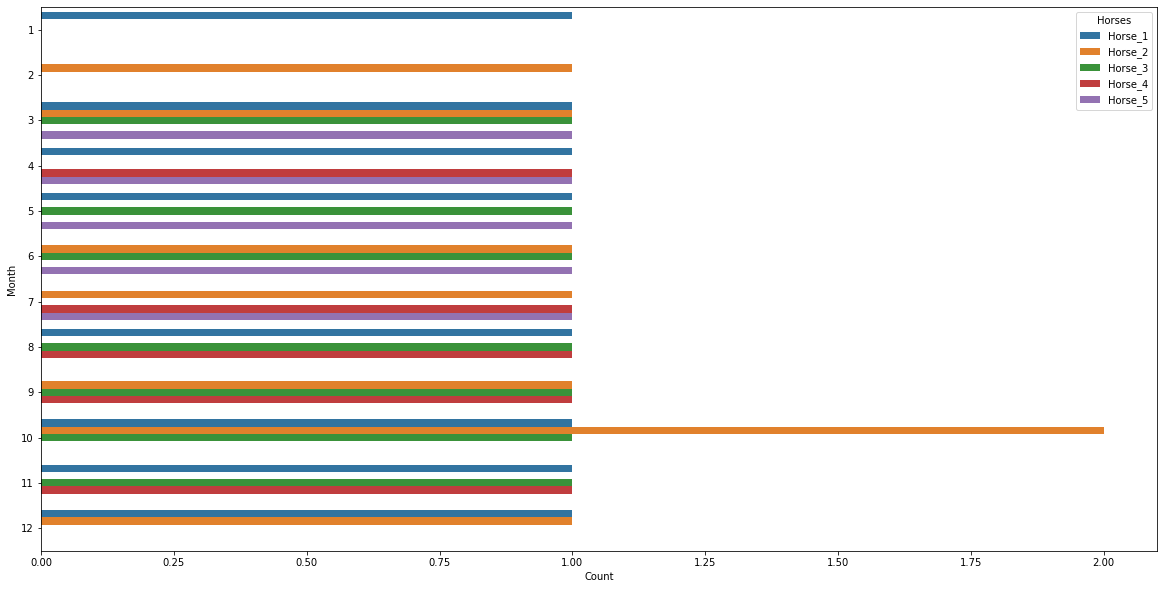

In [156]:
plt.figure(figsize=(20,10))
sns.barplot(y="Month", x="Count", hue="Horses", data=df_melted, linewidth=0.01, orient="h")
plt.show()

In [157]:
#Only get columns where at least one value is 1
data = data[data[horses.columns[:n]].sum(axis=1) != 0].reset_index(drop=True)

In [158]:
data

,Month,Date,Destination,Category,Origin,Destination_Long,Destination_Lat,Origin_Long,Origin_Lat,Distance,...,Horse_1_Drain,Horse_1_Allowance,Horse_2_Drain,Horse_2_Allowance,Horse_3_Drain,Horse_3_Allowance,Horse_4_Drain,Horse_4_Allowance,Horse_5_Drain,Horse_5_Allowance
0,1,2022-01-28,Ebreichsdorf,CSN-B*,Zwentendorf,16.391632,47.966111,16.43302,48.610603,98.7357,...,14.55,1,16.20,1,15.75,1,13.95,1,15.75,1
1,2,2022-02-19,Tulln an der Donau,CSN-C,Zwentendorf,16.056774,48.331169,16.43302,48.610603,55.9459,...,10.30,1,9.50,1,9.20,1,10.90,1,10.80,1
2,3,2022-04-03,Ebreichsdorf,CSI2*,Zwentendorf,16.391632,47.966111,16.43302,48.610603,98.7357,...,23.50,1,25.75,1,23.00,1,26.25,1,23.50,1
3,4,2022-04-14,Linz-Ebelsberg,CSI3*,Zwentendorf,14.347104,48.251974,16.43302,48.610603,215.8538,...,28.20,1,27.90,1,27.60,1,31.20,1,30.30,1
4,5,2022-12-05,Wiener Neustadt - Lake Arena,CSN-A*,Zwentendorf,16.197662,47.819735,16.43302,48.610603,117.1965,...,25.75,1,24.50,1,27.25,1,26.25,1,26.75,1
5,6,2022-06-16,Ebreichsdorf,CSI2*,Zwentendorf,16.391632,47.966111,16.43302,48.610603,98.7357,...,27.00,1,24.00,1,25.75,1,22.75,1,25.50,1
6,7,2022-05-07,Wiener Neustadt - Lake Arena,CSI3*,Zwentendorf,16.197662,47.819735,16.43302,48.610603,117.1965,...,29.10,1,32.10,1,27.60,1,27.30,1,27.90,1
7,8,2022-08-25,Wiener Neustadt - Lake Arena,CSI2*,Zwentendorf,16.197662,47.819735,16.43302,48.610603,117.1965,...,26.75,1,24.75,1,23.00,1,25.25,1,22.75,1
8,9,2022-09-14,Lamprechtshausen,CSI2*,Zwentendorf,12.955491,47.992615,16.43302,48.610603,359.9878,...,27.00,1,23.25,1,24.75,1,25.25,1,23.75,1
9,10,2022-10-13,Wiener Neustadt - Lake Arena,CSN-A*,Zwentendorf,16.197662,47.819735,16.43302,48.610603,117.1965,...,25.50,1,23.00,1,26.00,1,25.00,1,23.00,1


In [159]:
print("You will compete in {} different competitions this year.".format(len(data)))
print("Your horses will compete in categories {} of competitions.".format(", ".join(list(data["Category"].unique()))))

You will compete in 13 different competitions this year.
Your horses will compete in categories CSN-B*, CSN-C, CSI2*, CSI3*, CSN-A*, CSI4* of competitions.


In [160]:
#Initialize map at origin
first_row = data.iloc[1,:]
base_lat = first_row["Origin_Lat"]
base_long = first_row["Origin_Long"]
m = folium.Map(location=[base_lat, base_long], zoom_start=8)

colours = {
    "CSN-C": "lightblue",
    "CSN-B": "blue",
    "CSN-B*": "blue",
    "CSN-A": "darkblue",
    "CSN-A*": "darkblue",
    "CSI1*": "lightred",
    "CSI2*": "red",
    "CSI3*": "darkred",
    "CSI4*": "darkred",
}

#Add marker to origin
folium.Marker(
    [base_lat, base_long], popup="<i>{}</i>".format(first_row["Origin"]), tooltip="Home",icon=folium.Icon(color="red", icon='home')).add_to(m)


In [161]:
#Populate tournaments as markers on the map. The user can click the marker and get info on which horses to send.
for index, row in data.iterrows():
    dest_lat = row["Destination_Lat"]
    dest_long = row["Destination_Long"]
    
    selected_horses = []
    
    for col in list(horses.columns):
        if int(row[col]) == 1:
            selected_horses.append(col)
            
    
    
    folium.Marker(
    [dest_lat, dest_long], popup="<i>{}</i>"
        .format(" ".join([row["Category"].replace("\n", ""), " ".join(selected_horses)])), 
        tooltip=" ".join([row["Category"].replace(" ", ""),row["Destination"]]), 
        icon=folium.Icon(color=colours[row["Category"]])
    ).add_to(m)
    
m